In [1]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.regularizers import l2

num_classes = 30  # nombre de classes dans ton dataset
input_shape = (128,128, 3)

# Charger MobileNetV2 pré-entraîné
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)

# Geler le backbone pour commencer
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(64, activation='relu',kernel_regularizer=l2(1e-4))(x)
x = Dropout(0.5)(x)
outputs = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=outputs)

model.compile(optimizer=tf.keras.optimizers.Adam(0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

2025-12-10 17:15:09.833262: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-10 17:15:10.237267: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-10 17:15:18.342317: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-10 17:15:21.231182: E external/local_xla/xla/stream_executor/cuda/cuda_p

In [2]:
import numpy as np
import pickle
from sklearn.model_selection import train_test_split

# --- Charger CIFAR-100 ---
data = np.load("../data/cifar100.npz")
x_train, y_train = data['x_train'], data['y_train']
x_test, y_test   = data['x_test'], data['y_test']

# Flatten labels si nécessaire
y_train = y_train.flatten()
y_test  = y_test.flatten()

# Charger les noms des classes depuis le fichier meta
def load_cifar100_meta(path):
    with open(path, 'rb') as f:
        meta = pickle.load(f, encoding='latin1')
    return meta

meta = load_cifar100_meta("../data/cifar-100-python/meta")
class_names = meta['fine_label_names']

# --- Classes à garder ---
selected_classes = [
    'bottle','bowl','can','cup','plate',
    'apple','mushroom','orange','pear','sweet_pepper',
    'clock','keyboard','lamp','telephone','television',
    'bed','chair','couch','table','wardrobe',
    'bicycle','bus','motorcycle','pickup_truck','train',
    'lawn_mower','rocket','streetcar','tank','tractor'
]

# Convertir en indices CIFAR-100
selected_indices = [class_names.index(c) for c in selected_classes]

# --- Filtrer les données ---
mask_train = np.isin(y_train, selected_indices)
mask_test  = np.isin(y_test, selected_indices)

x_train_filtered = x_train[mask_train]
y_train_filtered = y_train[mask_train]

x_test_filtered  = x_test[mask_test]
y_test_filtered  = y_test[mask_test]

x_train_filtered = np.uint8(x_train_filtered*255)
x_test_filtered = np.uint8(x_test_filtered*255)


print("Train filtré :", x_train_filtered.shape, y_train_filtered.shape)
print("Test filtré  :", x_test_filtered.shape, y_test_filtered.shape)

# --- Remapper les labels de 0 à 29 ---
new_label_map = {old: i for i, old in enumerate(selected_indices)}
y_train_filtered = np.array([new_label_map[y] for y in y_train_filtered])
y_test_filtered  = np.array([new_label_map[y] for y in y_test_filtered])

print("Labels train :", np.unique(y_train_filtered))
print("Labels test  :", np.unique(y_test_filtered))

# --- Créer un ensemble de validation (10% du training) ---
x_train_final, x_val, y_train_final, y_val = train_test_split(
    x_train_filtered, y_train_filtered, test_size=0.1, 
    random_state=42, stratify=y_train_filtered
)

import tensorflow as tf

x_train_filtered = tf.image.resize(
    x_train_filtered, (128, 128), method='bicubic'
).numpy().astype(np.uint8)

x_val = tf.image.resize(
    x_val, (128, 128), method='bicubic'
).numpy().astype(np.uint8)
x_test_filtered = tf.image.resize(
    x_test_filtered, (128, 128), method='bicubic'
).numpy().astype(np.uint8)


print("Shapes après split :")
print("x_train:", x_train_final.shape, "y_train:", y_train_final.shape)
print("x_val:", x_val.shape, "y_val:", y_val.shape)
print("x_test:", x_test_filtered.shape, "y_test:", y_test_filtered.shape)


Train filtré : (15000, 64, 64, 3) (15000,)
Test filtré  : (3000, 64, 64, 3) (3000,)
Labels train : [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
Labels test  : [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
Shapes après split :
x_train: (13500, 64, 64, 3) y_train: (13500,)
x_val: (1500, 128, 128, 3) y_val: (1500,)
x_test: (3000, 128, 128, 3) y_test: (3000,)


In [3]:
x_train_filtered[0]

array([[[250, 250, 248],
        [249, 249, 247],
        [249, 249, 246],
        ...,
        [249, 250, 246],
        [249, 250, 246],
        [249, 250, 246]],

       [[250, 250, 248],
        [249, 249, 247],
        [249, 249, 246],
        ...,
        [248, 250, 245],
        [248, 250, 245],
        [249, 250, 245]],

       [[250, 250, 247],
        [249, 249, 247],
        [249, 249, 245],
        ...,
        [248, 250, 245],
        [248, 250, 245],
        [249, 250, 245]],

       ...,

       [[231, 231, 222],
        [231, 230, 221],
        [231, 230, 221],
        ...,
        [230, 226, 223],
        [231, 229, 227],
        [232, 230, 228]],

       [[232, 232, 225],
        [232, 232, 224],
        [232, 231, 224],
        ...,
        [229, 227, 223],
        [231, 229, 227],
        [232, 230, 228]],

       [[233, 233, 226],
        [233, 233, 226],
        [233, 232, 225],
        ...,
        [229, 227, 224],
        [231, 229, 227],
        [232, 230, 228]]

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
)

# Pas d'augmentation pour validation
val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

# Générateur pour l'entraînement
train_generator = train_datagen.flow(
    x_train_filtered, y_train_filtered, batch_size=32
)

# Générateur pour la validation
val_generator = val_datagen.flow(
    x_val, y_val,
    batch_size=32,
    shuffle=False
)


In [5]:
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

checkpoint_bf_ft = ModelCheckpoint(
    filepath="../models/training_checkpoint_bf_ft.keras",
    save_weights_only=False,  # <--- important : sauver modèle + optimizer
    save_best_only=False,     # <--- pour avoir un checkpoint à chaque epoch
    save_freq="epoch",
    verbose=1
)

checkpoint_ft = ModelCheckpoint(
    filepath="../models/training_checkpoint_ft.keras",
    save_weights_only=False,  # <--- important : sauver modèle + optimizer
    save_best_only=False,     # <--- pour avoir un checkpoint à chaque epoch
    save_freq="epoch",
    verbose=1
)

callbacks_bf_ft = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ReduceLROnPlateau(factor=0.2, patience=2),
    checkpoint_bf_ft
]

callbacks_ft = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ReduceLROnPlateau(factor=0.2, patience=2),
    checkpoint_ft
]



In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

# Phase 1 : entraînement du top classifier
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=15,
    callbacks=callbacks_bf_ft   # <-- CALLBACK ICI AUSSI
)

# Phase 2 : fine-tuning
base_model.trainable = True
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history_finetune = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=15,
    callbacks=callbacks_ft   # <-- CALLBACK ICI
)


/home/zakaria-el-guazzar/anaconda3/lib/python3.13/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step - accuracy: 0.0645 - loss: 3.5528
Epoch 1: saving model to ../models/training_checkpoint_bf_ft.keras
469/469 ━━━━━━━━━━━━━━━━━━━━ 153s 300ms/step - accuracy: 0.0971 - loss: 3.3051 - val_accuracy: 0.3213 - val_loss: 2.7642 - learning_rate: 1.0000e-04
Epoch 2/15
  9/469 ━━━━━━━━━━━━━━━━━━━━ 2:27 321ms/step - accuracy: 0.1738 - loss: 3.0967

In [ ]:
from tensorflow.keras.models import load_model

model = load_model("../models/training_checkpoint.keras")
history_resume = model.fit(
    train_generator,
    validation_data=val_generator,
    initial_epoch=model.optimizer.iterations.numpy() // len(train_generator),
    epochs=20,
    callbacks=[checkpoint_full]
)


Epoch 6/20


KeyboardInterrupt: 

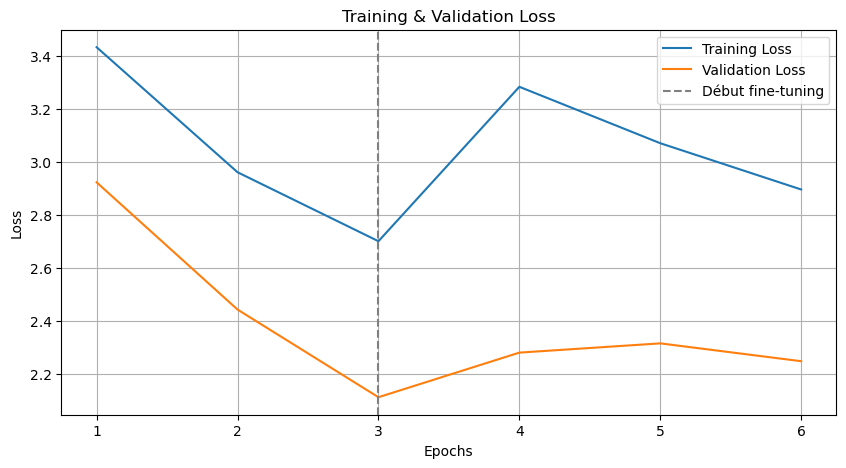

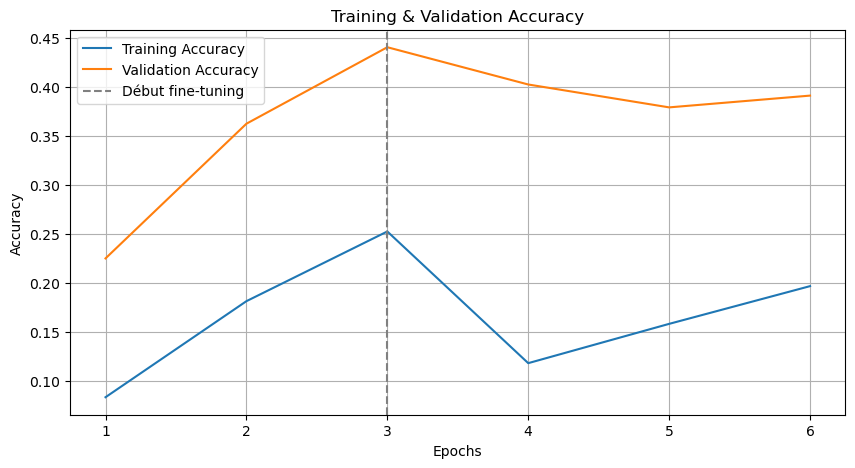

In [13]:
import matplotlib.pyplot as plt

# Récupération des métriques pour la phase 1
loss1 = history.history['loss']
val_loss1 = history.history['val_loss']
acc1 = history.history['accuracy']
val_acc1 = history.history['val_accuracy']

# Récupération des métriques pour la phase 2
loss2 = history_finetune.history['loss']
val_loss2 = history_finetune.history['val_loss']
acc2 = history_finetune.history['accuracy']
val_acc2 = history_finetune.history['val_accuracy']

# Concaténation pour faire une seule courbe continue
loss = loss1 + loss2
val_loss = val_loss1 + val_loss2
acc = acc1 + acc2
val_acc = val_acc1 + val_acc2

# Nombre total d'époques
epochs_total = range(1, len(loss) + 1)

# ---- PLOT LOSS ----
plt.figure(figsize=(10,5))
plt.plot(epochs_total, loss, label='Training Loss')
plt.plot(epochs_total, val_loss, label='Validation Loss')
plt.axvline(x=len(loss1), color='gray', linestyle='--', label="Début fine-tuning")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# ---- PLOT ACCURACY ----
plt.figure(figsize=(10,5))
plt.plot(epochs_total, acc, label='Training Accuracy')
plt.plot(epochs_total, val_acc, label='Validation Accuracy')
plt.axvline(x=len(acc1), color='gray', linestyle='--', label="Début fine-tuning")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training & Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()


In [2]:
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.model_selection import train_test_split
import numpy as np
import pickle


# ============================================================
# 1) CHARGEMENT DES DONNÉES CIFAR-100 + FILTRAGE
# ============================================================

def load_cifar100_meta(path):
    with open(path, 'rb') as f:
        meta = pickle.load(f, encoding='latin1')
    return meta


data = np.load("../data/cifar100.npz")
x_train, y_train = data['x_train'], data['y_train'].flatten()
x_test, y_test = data['x_test'], data['y_test'].flatten()

meta = load_cifar100_meta("../data/cifar-100-python/meta")
class_names = meta['fine_label_names']

selected_classes = [
    'bottle','bowl','can','cup','plate',
    'apple','mushroom','orange','pear','sweet_pepper',
    'clock','keyboard','lamp','telephone','television',
    'bed','chair','couch','table','wardrobe',
    'bicycle','bus','motorcycle','pickup_truck','train',
    'lawn_mower','rocket','streetcar','tank','tractor'
]

selected_indices = [class_names.index(c) for c in selected_classes]

mask_train = np.isin(y_train, selected_indices)
mask_test = np.isin(y_test, selected_indices)

x_train = x_train[mask_train]
y_train = y_train[mask_train]
x_test = x_test[mask_test]
y_test = y_test[mask_test]

# Remapper labels
new_label_map = {old: i for i, old in enumerate(selected_indices)}
y_train = np.array([new_label_map[y] for y in y_train])
y_test = np.array([new_label_map[y] for y in y_test])


# ============================================================
# 2) SPLIT TRAIN / VAL
# ============================================================
x_train, x_val, y_train, y_val = train_test_split(
    x_train, y_train, test_size=0.1, random_state=42, stratify=y_train
)


# ============================================================
# 3) PIPELINE tf.data OPTIMISÉ (CPU friendly)
# ============================================================

def preprocess(image, label):
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = preprocess_input(image)      # MobileNetV2 preprocessing
    return image, label

def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.image.random_crop(image, size=(56, 56, 3))
    image = tf.image.resize(image, (64, 64))
    return image, label


batch_size = 32

train_ds = (
    tf.data.Dataset.from_tensor_slices((x_train, y_train))
    .shuffle(10000)
    .map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    .map(augment, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(batch_size)
    .prefetch(tf.data.AUTOTUNE)
)

val_ds = (
    tf.data.Dataset.from_tensor_slices((x_val, y_val))
    .map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(batch_size)
    .prefetch(tf.data.AUTOTUNE)
)

test_ds = (
    tf.data.Dataset.from_tensor_slices((x_test, y_test))
    .map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(batch_size)
)


# ============================================================
# 4) CRÉATION DU MODÈLE AVEC AMÉLIORATIONS
# ============================================================

def build_model(num_classes):
    base = MobileNetV2(input_shape=(64,64,3), include_top=False, weights="imagenet")
    base.trainable = False  # phase 1

    x = layers.GlobalAveragePooling2D()(base.output)
    x = layers.Dense(256, activation='relu', kernel_regularizer=l2(1e-4))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    output = layers.Dense(num_classes, activation='softmax')(x)

    model = Model(base.input, output)
    return model


num_classes = 30
model = build_model(num_classes)

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)


# ============================================================
# 5) CALLBACKS
# ============================================================

checkpoint = ModelCheckpoint(
    "checkpoint_best.keras",
    monitor="val_accuracy",
    save_best_only=True,
    verbose=1
)

callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ReduceLROnPlateau(factor=0.2, patience=2, verbose=1),
    checkpoint
]


# ============================================================
# 6) ENTRAÎNEMENT PHASE 1 (TOP CLASSIFIER)
# ============================================================
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=callbacks
)


# ============================================================
# 7) FINE-TUNING PROGRESSIF (MEILLEURE STRATÉGIE CPU)
# ============================================================

# on dégèle les derniers 30 couches du backbone
for layer in model.layers[-30:]:
    layer.trainable = True

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(label_smoothing=0.1),
    metrics=['accuracy']
)

history_ft = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=callbacks
)


# ============================================================
# 8) ÉVALUATION SUR TEST
# ============================================================

test_loss, test_acc = model.evaluate(test_ds)
print("Accuracy test final :", test_acc)


/tmp/ipykernel_11615/3223937521.py:109: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base = MobileNetV2(input_shape=(64,64,3), include_top=False, weights="imagenet")


Epoch 1/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.0309 - loss: 4.0729
Epoch 1: val_accuracy improved from None to 0.04000, saving model to checkpoint_best.keras
422/422 ━━━━━━━━━━━━━━━━━━━━ 47s 91ms/step - accuracy: 0.0324 - loss: 3.8983 - val_accuracy: 0.0400 - val_loss: 3.4545 - learning_rate: 0.0010
Epoch 2/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.0355 - loss: 3.6818
Epoch 2: val_accuracy improved from 0.04000 to 0.05333, saving model to checkpoint_best.keras
422/422 ━━━━━━━━━━━━━━━━━━━━ 36s 85ms/step - accuracy: 0.0343 - loss: 3.6449 - val_accuracy: 0.0533 - val_loss: 3.4402 - learning_rate: 0.0010
Epoch 3/20
379/422 ━━━━━━━━━━━━━━━━━━━━ 3s 81ms/step - accuracy: 0.0361 - loss: 3.5681

KeyboardInterrupt: 